# Projekt 2: Neural Style Transfer

Herzlich Willkommen zu *Projekt 2: Neural Style Transfer*!

<table style="width:100%">
    <tr>
        <th><img src="altgebaeude.jpg" alt="" style="width: 333px;"></th>
        <th><img src="vangogh.jpg" alt="" style="width: 333px;"></th>
        <th><img src="altgebaeude_stilisiert.png" alt="" style="width: 333px;"></th>
    </tr>
    <tr>
        <th>Content Image $\mathbf{c}$</th>
        <th>Style Image $\mathbf{s}$</th>
        <th>Generated Image $\mathbf{x}$</th>
    </tr>
</table> 


Hinter dem Begriff *Neural Style Transfer* verbirgt sich ein Ansatz, mit welchem sich ein gegebenes Bild (*Content Image* $\mathbf{c}$, meist eine Fotografie) dahingehend verändern lässt, dass es stilistisch einem weiteren gegebenen Bild (*Style Image* $\mathbf{s}$, oft ein Gemälde) ähnelt. Zu diesem Zweck wird eine spezielle Verlustfunktion minimiert, in welcher ein vortrainiertes tiefes konvolutionelles neuronales Netz eine tragende Rolle spielt. Ausgewählte Schichten dieses neuronalen Netzes werden verwendet, um einen gewissen Abstand zwischen dem gesuchten Bild (*Generated Image* $\mathbf{x}$) und dem *Content Image* sowie zwischen dem Stil des *Generated Image* und dem Stil des *Style Imgage* zu messen. Die Idee zu diesem Verfahren stammt aus dem Artikel <a href="https://studip.tu-braunschweig.de/plugins.php/courseware/courseware?cid=855c4849a3c8b348f07d6bd07ec631f4&selected=762018#">A Neural Algorithm of Artistic Style</a> von Leon Gatys, Alexander Ecker und Matthias Bethge.

Hinter dem Verfahren steckt der grundlegende Gedanke, dass Outputs konvolutioneller Schichten eines neuronalen Netzes einen Hinweis darauf geben, ob gewisse gelernte Muster in Bereichen eines eingegebenen Bildes enthalten sind oder nicht. Jeder Filter einer konvolutionellen Schicht ist für ein Muster zuständig, und je tiefer im Netz ein Filter platziert ist, desto komplexer und abstrakter können die extrahierten Informationen sein. Während für den Vergleich von *Content Image* und *Generated Imaged* Abstände zwischen den jeweiligen Outputs konvolutioneller Schichten direkt gemessen werden, geht die Definition des verwendeten Abstandes zur Messung stilistischer Ähnlichkeit noch einen Schritt weiter. Hierfür werden Korrelationen (innere Produkte) unter allen Outputkanälen einer konvolutionellen Schicht gemessen und in einer sogenannten *Gram-Matrix* zusammengefasst. Der Vergleich von *Style Image* und *Generated Image* findet dann über mehrere solche Matrizen bezüglich verschiedener Schichten statt. Weitere Details finden Sie weiter unten in diesem Notebook, in oben genanntem Artikel und in dem Buchkapitel <a href="https://studip.tu-braunschweig.de/plugins.php/courseware/courseware?cid=855c4849a3c8b348f07d6bd07ec631f4&selected=762016">Neural Style Transfer</a> aus *Generative Deep Learning* von David Forster.

<img src="graph_2.png" alt="" style="width: 1000px;"/>

In diesem Projekt werden wir das fertig trainierte und in Keras direkt verfügbare konvolutionelle neuronale Netz <a href="https://keras.io/applications/#vgg19">VGG19</a> (siehe auch <a href="https://arxiv.org/pdf/1409.1556.pdf">Very Deep Convolutional Networks for Large-Scale Image Recognition</a> von Karen Simonyan und Andrew Zisserman) verwenden. Wir verfolgen also hier nicht das Ziel, die Parameter eines neuronalen Netzes zu lernen, sondern wollen einzig und allein das gesuchte *Generated Image* $\mathbf{x}$ bestimmen. Obwohl wir uns dabei mit *Neural Style Transfer* auf eine spezielle Anwendung konzentrieren, lernen Sie weitere wichtige Grundlagen für eine fortgeschrittene Nutzungsweise von Keras und TensorFlow kennen. Um die oben genannten Outputs konvolutioneller Schichten sowie *Gram-Matrizen* aus eingegebenen Bildern zu berechnen, benötigen wir die <a href="https://studip.tu-braunschweig.de/plugins.php/courseware/courseware?cid=855c4849a3c8b348f07d6bd07ec631f4&selected=762027#">Keras Functional API</a> sowie die <a href="https://studip.tu-braunschweig.de/plugins.php/courseware/courseware?cid=855c4849a3c8b348f07d6bd07ec631f4&selected=762029">Keras Subclassing API</a>, welche die Möglichkeiten zur Definition von Keras-Modellen im Vergleich mit der bereits bekannten <a href="https://studip.tu-braunschweig.de/plugins.php/courseware/courseware?cid=855c4849a3c8b348f07d6bd07ec631f4&selected=762025">Keras Sequential API</a> entscheidend erweitern. Darüber hinaus werden wir <a href="https://studip.tu-braunschweig.de/plugins.php/courseware/courseware?cid=855c4849a3c8b348f07d6bd07ec631f4&selected=762037">TensorFlow-Funktionen</a> und <a href="https://studip.tu-braunschweig.de/plugins.php/courseware/courseware?cid=855c4849a3c8b348f07d6bd07ec631f4&selected=762034#">automatische Differentiation</a> nutzen, um <a href="https://studip.tu-braunschweig.de/plugins.php/courseware/courseware?cid=855c4849a3c8b348f07d6bd07ec631f4&selected=762036">individuelle Trainingsschleifen</a> in TensorFlow zu realisieren.

Abzugeben sind schließlich drei von Ihnen mit *Neural Style Transfer* generierte Bilder. Mit diesen abgegebenen Bildern nehmen Sie am **Neural Art Contest** teil, der im Rahmen der **Abschlussveranstaltung am 05.02.2020** stattfindet. Hierbei können alle Besucher für Kunstwerke abstimmen und es wird ein Siegerteam gekürt. Der Zeitraum für die Bearbeitung des Projektes dauert bis zum **04. Dezember 2019**. Die Abnahme erfolgt spätestens an diesem Tag zwischen 11:30 und 13:00 Uhr im CIP-Pool. Weiterhin senden Sie bitte bis zu diesem Termin das bearbeitete Notebook sowie alle unten angegebenen Dateien an **ch.brauer@tu-bs.de** sowie **n.breustedt@tu-bs.de**.

In [9]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
import PIL.Image
import time

## 2.1 Bilder laden und formatieren mit TensorFlow

1. Schreiben Sie eine Funktion ```load_img(path_to_img, max_dim)```, welche ein unter dem Pfad ```path_to_img``` abgelegtes Bild im Format BMP, JPEG oder PNG einliest und dessen Größe anpasst. Als Rückgabewert soll ein vierdimensionaler Tensor ```img``` vom Datentyp ```tf.float32``` mit Werten zwischen Null und Eins geliefert werden. Höhe und Breite des eingelesenen Bildes sollen so skaliert werden, dass der maximale Wert von ```img.shape[1]``` (Höhe in Pixeln) und ```img.shape[2]``` (Breite in Pixeln) genau ```max_dim``` entspricht, und es soll ```img.shape[0] = 1``` (Stapelgröße) und ```img.shape[3] = 3``` (Anzahl Kanäle) gelten. Gehen Sie folgendermaßen vor:

   1.1 Nutzen Sie zunächst ```tf.io.read_file```, ```tf.image.decode_image``` und ```tf.image.convert_image_dtype``` (in dieser Reihenfolge), um das Bild einzulesen und den Datentyp zu konvertieren.
   
   1.2 Verwenden Sie ```tf.image.resize```, um Höhe und Breite des Bildes gleichmäßig derart zu skalieren, dass das Maximum beider Werte anschließend ```max_dim``` entspricht.
   
   1.3 Wenden Sie ```tf.expand_dims``` an, um dem Bild eine Dimension für die Stapelgröße hinzuzufügen.

In [10]:
def load_img(path_to_img, max_dim):
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img)
    img = tf.image.convert_image_dtype(image=img,dtype=tf.float32)
    aspekt = img.shape[0]/img.shape[1]
    if aspekt>1:
        new_height = max_dim
        new_width = tf.cast(max_dim/aspekt,tf.int32)
    else:
        new_height = tf.cast(max_dim*aspekt,tf.int32)
        new_width = max_dim
    img = tf.image.resize(img,(new_height,new_width))
    img = tf.expand_dims(img,0)
    return img

2. Rufen Sie ```load_img``` mit ```max_dim = 512``` auf, um die Bilder ```altgebaeude.jpg``` und ```vangogh.jpg``` in die Variablen ```content_image``` bzw. ```style_image``` zu schreiben.
3. Nutzen Sie ```plt.imshow```, um beide Bilder anzeigen zu lassen.

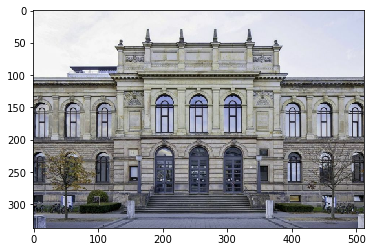

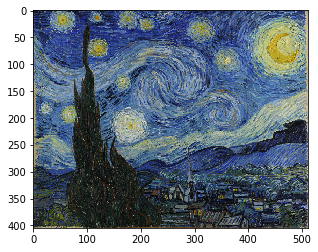

In [11]:
path_content = '/home/ajay/Desktop/fpds/Projekt_2/altgebaeude.jpg'
path_style = '/home/ajay/Desktop/fpds/Projekt_2/vangogh.jpg'
content_image = load_img(path_content,512)
style_image = load_img(path_style,512)
plt.figure()
plt.imshow(content_image[0,...])
plt.figure()
plt.imshow(style_image[0,...])

4. Wenden Sie ```tf.shape``` nacheinander auf ```content_image``` und ```style_image``` an und lassen Sie beide Ergebniss ausgeben.

In [12]:
print(tf.shape(content_image))
print(tf.shape(style_image))

tf.Tensor([  1 337 512   3], shape=(4,), dtype=int32)
tf.Tensor([  1 405 512   3], shape=(4,), dtype=int32)


**Checkpoint:** Sie sollten folgende Ausgaben erhalten haben:

```
tf.Tensor([  1 337 512   3], shape=(4,), dtype=int32)
tf.Tensor([  1 405 512   3], shape=(4,), dtype=int32)
```

## 2.2 Nutzung vortrainierter Modelle in Keras

Mittels ```tf.keras.applications``` lassen sich auf einfache Weise verschiedene fertig trainierte neuronale Netze laden, darunter ```VGG19```, welches wir in diesem Projekt verwenden wollen. Bevor wir unser eigentliches Thema Style Transfer in Angriff nehmen, betrachten wir am Beispiel der zwei soeben geladenen Bilder, wie wir ein vortrainiertes Modell direkt zum Zweck der Mehrfachklassifikation nutzen können.

5. Laden Sie ```tf.keras.applications.VGG19``` mit den Argumenten ```include_top = True``` und ```weights = "imagenet"``` und speichern Sie es in der Variablen ```vgg19```.

Das erstgenannte Argument sorgt dafür, sowohl die vorderen konvolutionellen Schichten als auch die hinteren vollständig verbundenen Schichten von ```VGG19``` geladen werden. Umgekehrt lässt sich mittels ```include_top = False``` eine Version ohne die vollständig verbundenen Schichten laden. Die Variante ohne vollständig verbundene Schichten besitzt unter anderem den Vorteil, dass Bilder beliebiger Breite und Höhe als Input akzeptiert werden, was wir später im Rahmen von Style Transfer auch ausnutzen. Die Variante mit vollständig verbundenen Schichten, die Sie hier laden sollen, akzeptiert hingegen ausschließlich Bilder mit Höhe und Breite 224. Das zweite Argument ```weights = "imagenet"``` veranlasst, dass auch tatsächlich eine auf dem Datensatz ```imagenet``` vortrainierte Version geladen wird. Mittels ```weights = None``` lässt sich alternativ eine Version mit zufällig initialisierten Gewichten laden.

In [5]:
vgg19 = tf.keras.applications.VGG19(include_top=True,weights="imagenet")

6. Verschaffen Sie sich mit Hilfe von ```tf.keras.models.Model.summary``` einen Überblick über das geladene Modell.

In [6]:
tf.keras.Model.summary(vgg19)

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Jedes Modell in ```keras.applications``` bringt eine Preprocessing-Funktion mit, die vorab auf Inputs angewendet werden sollte. Im Fall von ```VGG19``` erwartet diese Funktion ein Bild mit Pixelwerten zwischen 0 und 255 als Argument.

7. Wenden Sie ```tf.keras.applications.vgg19.preprocess_input``` auf eine Version von ```content_image``` mit entsprechend skalierten Pixelwerten an und speichern Sie das Ergebnis in ```content_image_pp```. Verwenden Sie dann ```tf.image.resize```, um Höhe und Breite von ```content_image_pp``` derart anzupassen, dass Sie anschließend ```vgg``` auf das Ergebnis ```content_image_rs``` anwenden können. Machen Sie letzeres und speichern Sie das Ergebnis in ```prediction_probabilities```.

In [7]:
content_image_pp = tf.keras.applications.vgg19.preprocess_input(content_image*255)
content_image_rs = tf.image.resize(content_image_pp,(224,224))
prediction_probabilities = vgg19(content_image_rs)

8. Rufen Sie nun ```tf.keras.applications.vgg19.decode_predictions``` mit Argumenten ```prediction_probabilities.numpy()``` und ```top = 10``` auf, um die Top-10-Klassen samt Wahrscheinlichkeiten für den gegebenen Input zu ermitteln. Speichern Sie das Ergebnis in ```predicted_top_10``` und lassen Sie anschließend ```[(class_name, prob) for (number, class_name, prob) in predicted_top_10[0]]``` ausgeben.

In [8]:
predicted_top_10 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy(),top=10)
print([(class_name, prob) for (number, class_name, prob) in predicted_top_10[0]])

[('palace', 0.99166054), ('triumphal_arch', 0.0025819296), ('monastery', 0.001254463), ('library', 0.0010796444), ('fountain', 0.0008085531), ('church', 0.00045474822), ('cinema', 0.0003220932), ('castle', 0.00030228062), ('obelisk', 0.00029674143), ('bell_cote', 0.00021813066)]


**Checkpoint:** Sie sollten folgende Ausgabe erhalten haben:
```
[('palace', 0.9914498),
 ('triumphal_arch', 0.002679715),
 ('monastery', 0.0013206728),
 ('library', 0.0011177801),
 ('fountain', 0.0008800263),
 ('church', 0.00044454288),
 ('castle', 0.00030994107),
 ('obelisk', 0.00029764447),
 ('dome', 0.00022929681),
 ('cinema', 0.00022750047)]
 ```

Laut ```VGG19``` ist unser Altgebäude also höchstwahrscheinlich ein Palast!

9. Wiederholen Sie 7. und 8. mit ```style_image``` als Input.

In [9]:
style_image_pp = tf.keras.applications.vgg19.preprocess_input(style_image*255)
style_image_rs = tf.image.resize(style_image_pp,(224,224))
prediction_probabilities = vgg19(style_image_rs)
predicted_top_10 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy(),top=10)
print([(class_name, prob) for (number, class_name, prob) in predicted_top_10[0]])

[('jigsaw_puzzle', 0.15851744), ('prayer_rug', 0.11222446), ('shower_curtain', 0.09415145), ('pillow', 0.057611376), ('sarong', 0.043321446), ('quilt', 0.040860392), ('wool', 0.03166769), ('coral_reef', 0.028416598), ('cardigan', 0.026929695), ('book_jacket', 0.025868908)]


## 2.3 Definition eines Feature Extractors

Wir kommen nun zum Hauptthema dieses Projektes: *Neural Style Transfer*! Um die dortige Zielfunktion

$$J(\mathbf{x}, \mathbf{c}, \mathbf{s}) = \alpha \ J_\mathrm{content}(\mathbf{x}, \mathbf{c}) + \beta \ J_\mathrm{style}(\mathbf{x}, \mathbf{s})\qquad (*)$$

auswerten zu können, benötigen wir zunächst einen sogenannten *Feature Extractor*. Einerseits soll uns dieser die Outputs $\mathrm{a}^{[\ell](\mathbf{x})}$ und $\mathrm{a}^{[\ell](\mathbf{c})}$ ausgewählter konvolutioneller Schichten von ```VGG19``` liefern, welche wir für die Auswertung der Content-Verlustfunktion

$$J_\mathrm{content}(\mathbf{x}, \mathbf{c}) = \frac{1}{\vert L_\mathrm{content}\vert} \sum_{\ell\in L_\mathrm{content}}\frac12 \Vert \mathrm{a}^{[\ell](\mathbf{x})} - \mathrm{a}^{[\ell](\mathbf{c})} \Vert_2^2\qquad (**)$$

benötigen. Andererseits brauchen wir Gram-Matrizen $\mathrm{G}^{[\ell](\mathbf{x})}$ und $\mathrm{G}^{[\ell](\mathbf{s})}$, um die Style-Verlustfunktion

$$J_\mathrm{style}(\mathbf{x}, \mathbf{s}) = \frac{1}{\vert L_\mathrm{style}\vert} \sum_{\ell\in L_\mathrm{style}} \frac{1}{\left(2n^{[\ell]}_C \right)^2}\Vert \mathrm{G}^{[\ell](\mathbf{x})} - \mathrm{G}^{[\ell](\mathbf{s})} \Vert_2^2\qquad (***)$$

auszuwerten. Dabei ist

$$\mathrm{G}^{[\ell](\mathbf{x})}_{i, j} = \frac{1}{n^{[\ell]}_H n^{[\ell]}_W} \langle\mathrm{a}^{[\ell](\mathbf{x})}_{i}, \mathrm{a}^{[\ell](\mathbf{x})}_{j}\rangle\quad\text{für}\quad i, j =1,\dots,n^{[\ell]}_C\qquad (****)$$

und $\mathrm{a}^{[\ell](\mathbf{x})}_{i}$ und $\mathrm{a}^{[\ell](\mathbf{x})}_{j}$ stehen für den $i$-ten bzw. $j$-ten Kanal von $\mathrm{a}^{[\ell](\mathbf{x})}$.

10. Laden Sie ```VGG19``` erneut (siehe 5.), diesmal allerdings mit dem Argument ```include_top=False```. Lassen Sie anschließend die Namen aller Schichten in ```vgg.layers``` ausgeben.

In [10]:
vgg = tf.keras.applications.VGG19(include_top=False,weights="imagenet")
print([layer.name for layer in vgg.layers])

['input_2', 'block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_conv4', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_conv4', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_conv4', 'block5_pool']


**Checkpoint:** Sie sollten folgende Ausgabe erhalten haben:
```
input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool
```

Obige Ausgabe umfasst alle Schichten, die Sie zu $L_\mathrm{content}$ oder $L_\mathrm{style}$ hinzufügen können. Für den Moment legen wir uns auf folgende Wahl fest:

11. Legen Sie zwei Listen ```content_layers``` und ```style_layers``` an. Initialisieren Sie ```content_layers``` mit einem einzigen Element ```"block5_conv2"``` und ```style_layers``` mit fünf Elementen ```"block1_conv1"``` bis ```"block5_conv1"```. Speichern Sie in ```num_content_layers``` bzw. ```num_style_layers``` die Länge der jeweiligen Liste.

In [3]:
content_layers = ["block5_conv2"]
num_content_layers = len(content_layers)
style_layers = ["block1_conv1","block2_conv1","block3_conv1","block4_conv1","block5_conv1"]
num_style_layers = len(style_layers)

12. Schreiben Sie eine Funktion ```vgg_layers```, welche als Argument eine Liste ```layer_names``` erhält und ein Objekt ```model``` vom Typ ```keras.models.Model``` zurückgibt. Laden Sie zunächst ```VGG19``` ohne vollständig verbundene Schichten und mit auf ```imagenet``` trainierten Gewichten. Definieren Sie dann über die Keras Functional API ein Modell ```model```, welches die Inputschicht von ```VGG19``` übernimmt und als Output eine Liste aller in ```layer_names``` angegebenen Schichten von ```VGG19``` produziert.

In [1]:
def vgg_layers(layer_names):
    vgg1 = tf.keras.applications.VGG19(include_top=False,weights="imagenet")
    model = tf.keras.models.Model(inputs=vgg1.input,outputs=[vgg1.get_layer(layer).output for layer in layer_names])
    return model

In [8]:
vgg_layers(style_layers).output

[<tf.Tensor 'block1_conv1_2/Identity:0' shape=(None, None, None, 64) dtype=float32>,
 <tf.Tensor 'block2_conv1_2/Identity:0' shape=(None, None, None, 128) dtype=float32>,
 <tf.Tensor 'block3_conv1_2/Identity:0' shape=(None, None, None, 256) dtype=float32>,
 <tf.Tensor 'block4_conv1_2/Identity:0' shape=(None, None, None, 512) dtype=float32>,
 <tf.Tensor 'block5_conv1_2/Identity:0' shape=(None, None, None, 512) dtype=float32>]

**Checkpoint:** Obiger Aufruf von ```vgg_layers(style_layers).output``` sollte folgenden Output produzieren:
```
[<tf.Tensor 'block1_conv1_6/Identity:0' shape=(None, None, None, 64) dtype=float32>,
 <tf.Tensor 'block2_conv1_6/Identity:0' shape=(None, None, None, 128) dtype=float32>,
 <tf.Tensor 'block3_conv1_6/Identity:0' shape=(None, None, None, 256) dtype=float32>,
 <tf.Tensor 'block4_conv1_6/Identity:0' shape=(None, None, None, 512) dtype=float32>,
 <tf.Tensor 'block5_conv1_6/Identity:0' shape=(None, None, None, 512) dtype=float32>]
 ```

13. Schreiben Sie eine Funktion ```gram_matrix```, welche als Argument einen vierdimensionalen Tensor ```input_tensor``` (entspricht $\mathbf{a}^{[\ell](\mathbf{x})}$ bzw. $\mathbf{a}^{[\ell](\mathbf{s})}$) erhält und als Output die Gram-Matrix dieses Tensors gemäß $(****)$ liefert. Wenden Sie dazu zunächst die Funktion ```tf.linalg.einsum``` in geeigneter Weise an. Berücksichtigen Sie dabei, dass die führende Dimension von ```input_tensor``` die Stapelgröße repräsentiert und bei Berechnung der Gram-Matrix unangetastet bleibt.

In [14]:
def gram_matrix(input_tensor):
    gram = tf.linalg.einsum('aijb,aijc->abc',input_tensor,input_tensor)
    shape = tf.shape(input_tensor)
    produkt = tf.cast(shape[1]*shape[2],tf.float32)
    return gram/produkt

In [24]:
gram_matrix(vgg_layers(style_layers)(content_image)[0])

<tf.Tensor: id=8100, shape=(1, 64, 64), dtype=float32, numpy=
array([[[0.6793128 , 0.24996379, 0.27242476, ..., 0.06225346,
         0.36316112, 0.48768687],
        [0.24996379, 0.12582201, 0.13334161, ..., 0.01399269,
         0.17075   , 0.2168178 ],
        [0.27242476, 0.13334161, 0.1454681 , ..., 0.01353733,
         0.18991147, 0.24291667],
        ...,
        [0.06225346, 0.01399269, 0.01353733, ..., 0.03885941,
         0.04065544, 0.0411607 ],
        [0.36316112, 0.17075   , 0.18991147, ..., 0.04065544,
         0.31434813, 0.35955128],
        [0.48768687, 0.2168178 , 0.24291667, ..., 0.0411607 ,
         0.35955128, 0.4429307 ]]], dtype=float32)>

**Checkpoint:** Obiger Aufruf von ```gram_matrix(vgg_layers(style_layers)(content_image)[0])``` sollte folgenden Output produzieren (```id``` kann abweichen):
```
<tf.Tensor: id=5358, shape=(1, 64, 64), dtype=float32, numpy=
array([[[0.68184817, 0.25003228, 0.27254802, ..., 0.06256816,
         0.3623089 , 0.4875279 ],
        [0.25003228, 0.12591979, 0.13346936, ..., 0.01410388,
         0.1708877 , 0.21700618],
        [0.27254802, 0.13346936, 0.14569567, ..., 0.01362438,
         0.1902052 , 0.2433617 ],
        ...,
        [0.06256816, 0.01410388, 0.01362438, ..., 0.039074  ,
         0.04098042, 0.04138251],
        [0.3623089 , 0.1708877 , 0.1902052 , ..., 0.04098042,
         0.31539047, 0.36040032],
        [0.4875279 , 0.21700618, 0.2433617 , ..., 0.04138251,
         0.36040032, 0.4439834 ]]], dtype=float32)>
```

14. Vervollständigen Sie die Methode ```call``` der von ```tf.keras.models.Model``` abgeleiteten Klasse ```StyleContentModel```. Gehen Sie folgendermaßen vor:

    14.1 Das Argument ```inputs``` ist wiederum ein als vierdimensionaler Tensor gespeichertes Bild mit Pixelwerten zwischen Null und Eins. Wenden Sie zunächst ```tf.keras.applications.vgg19.preprocess_input``` auf eine geeignet skalierte Version von ```inputs``` an (verändern Sie nicht Höhe und Breite) und schreiben Sie das Ergebnis in ```preprocessed_input```.
    
    14.2 Wenden Sie das Attribut ```vgg``` auf ```preprocessed_input``` an und schreiben Sie das Ergebnis in ```outputs```.
    
    14.3 Teilen Sie die Liste ```outputs``` in zwei Listen ```style_outputs``` und ```content_outputs``` auf. Werfen Sie zunächst einen Blick auf die Initialisierung des Attributs ```vgg``` und leiten Sie daraus die einzig konsequente Aufteilung ab.
    
    14.4 Ersetzen Sie alle Elemente von ```style_outputs``` durch die zugehörigen Gram-Matrizen.

In [25]:
class StyleContentModel(tf.keras.models.Model):
    
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg =  vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False
        
    def call(self, inputs):
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        content_outputs, style_outputs = (outputs[self.num_style_layers:],outputs[:self.num_style_layers])
        
        style_outputs = [gram_matrix(element) for element in style_outputs]
        
        content_dict = {content_name:value for content_name, value in zip(self.content_layers, content_outputs)}
        style_dict = {style_name:value for style_name, value in zip(self.style_layers, style_outputs)}
        return {'content':content_dict, 'style':style_dict}

**Bemerkung:** Sie haben nun alle drei Keras APIs zur Definition von Modellen kennengelernt. In Projekt 1 haben Sie verschiedene Modelle mit Hilfe der *Keras Sequential API* erstellt. Oben in 12. haben Sie die *Keras Functional API* verwendet und in 14.4 schließlich die *Keras Subclassing API*. Die Flexibilität der genannten APIs steigt in der genannten Reihenfolge: Die Sequential API ist einfach in der Handhabung, erlaubt aber lediglich die Definition einfacher Modelle mit einem Input- und einem Outputtensor sowie aneinandergereihten Schichten dazwischen. Die Functional API erlaubt multiple Input- und Outputtensoren (letzteres haben wir ausgenutzt) und es ist zum Beispiel möglich, dass Aktivierungen eine oder mehrere Schichten überspringen (sogenannten *Skip Connections*). Die Möglichkeiten der Subclassing API gehen noch weit darüber hinaus. Innerhab der ```call``` Methode können beliebige TensorFlow-Funktionen (bei uns zur Berechnung der Gram-Matrix) und ebenfalls Kontrollstrukturen wie ```for``` und ```while``` angewendet werden. Ein Nachteil ist, dass sich mit der Subclassing API erstellte Modelle nicht ohne weiteren Aufwand speichern und laden lassen, was in diesem Projekt aber nicht von Interesse ist. Im Unterschied zu den zwei erstgenannten APIs, muss im Fall der Subclassing API zunächst eine Instanz der jeweiligen Klasse erzeugt werden, um ein verwendbares Modell zu erhalten. Damit fahren wir nun fort:

15. Erzeugen Sie eine Instanz ```extractor``` der Klasse ```StyleContentModel```, wobei Sie dem Konstruktor die oben definierten Listen ```style_layers``` und ```content_layers``` übergeben.

In [26]:
extractor = StyleContentModel(style_layers=style_layers,content_layers=content_layers)

Nun sind wir bereit, mit Hilfe von ```extractor``` die Verlustfunktionen $(*)$, $(**)$ und $(***)$ zu implementieren sowie zu minimieren!

## 2.4 Minimierung der Verlustfunktion

Im Rahmen von Neural Style Transfer ist letztlich das Optimierungsproblem

$$\min_{\mathbf{x}} J(\mathbf{x}, \mathbf{c}, \mathbf{s})$$

zu lösen, wobei $\mathbf{c}$ und $\mathbf{s}$ das *Content Image* bzw. das *Style Image* repräsentieren. Diese zwei Bilder sind gegeben, entsprechend sind also alle $\mathbf{a}^{[\ell](\mathbf{c})}$ in $(**)$ sowie alle $\mathbf{G}^{[\ell](\mathbf{s})}$ in $(***)$ ebenfalls konstant. Diese Größen berechnen wir nun vorab mit Hilfe von ```extractor```:

16. Wenden Sie ```extractor``` auf ```style_image``` an, um die zugehörigen Gram-Matrizen zu extrahieren und speichern Sie das Ergebnis in ```style_targets``` (entspricht einer Liste mit Elementen $\mathbf{G}^{[\ell](\mathbf{s})}$ für verschiedene $\ell$).

In [27]:
style_targets = extractor(style_image)['style']

In [28]:
style_targets["block1_conv1"]

<tf.Tensor: id=8739, shape=(1, 64, 64), dtype=float32, numpy=
array([[[ 2931.265  ,  1284.4825 ,   619.90674, ...,  1932.9645 ,
           701.17163,   962.8293 ],
        [ 1284.4825 ,  2936.343  ,   874.96106, ...,  1363.4104 ,
           921.5188 ,   693.0422 ],
        [  619.90674,   874.96106,   523.6385 , ...,   164.53883,
           512.51996,   542.68475],
        ...,
        [ 1932.9645 ,  1363.4104 ,   164.53883, ..., 12701.812  ,
          1295.3236 ,   629.686  ],
        [  701.17163,   921.5188 ,   512.51996, ...,  1295.3236 ,
          1374.7305 ,  1007.70996],
        [  962.8293 ,   693.0422 ,   542.68475, ...,   629.686  ,
          1007.70996,  1053.5671 ]]], dtype=float32)>

**Checkpoint:** Obiger Aufruf von ```style_targets["block1_conv1"]``` sollte folgenden Output produzieren (```id``` kann abweichen):
```
<tf.Tensor: id=6800, shape=(1, 64, 64), dtype=float32, numpy=
array([[[ 2939.3555 ,  1284.2178 ,   622.073  , ...,  1931.3914 ,
           702.777  ,   966.52844],
        [ 1284.2178 ,  2934.7964 ,   873.8534 , ...,  1362.9878 ,
           921.52594,   692.934  ],
        [  622.073  ,   873.8534 ,   523.7682 , ...,   164.43858,
           514.05597,   545.201  ],
        ...,
        [ 1931.3914 ,  1362.9878 ,   164.43858, ..., 12701.73   ,
          1293.5526 ,   627.3361 ],
        [  702.777  ,   921.52594,   514.05597, ...,  1293.5526 ,
          1377.959  ,  1011.51404],
        [  966.52844,   692.934  ,   545.201  , ...,   627.3361 ,
          1011.51404,  1059.9109 ]]], dtype=float32)>
```

17. Wenden Sie ```extractor``` auf ```content_image``` an, um die zugehörigen Aktivierungen zu extrahieren und speichern Sie das Ergebnis in ```content_targets``` (entspricht einer Liste mit Werten $\mathbf{a}^{[\ell](\mathbf{c})}$ für verschiedene $\ell$).

In [29]:
content_targets = extractor(content_image)['content']

In [30]:
content_targets["block5_conv2"][0][0]

<tf.Tensor: id=8999, shape=(32, 512), dtype=float32, numpy=
array([[  0.       ,   0.       , 152.74686  , ...,   0.       ,
          0.       ,   0.       ],
       [  0.       ,   0.       ,  36.351883 , ...,   0.       ,
          0.       ,   0.       ],
       [  0.       ,   0.       ,  57.17999  , ...,   0.       ,
          0.       ,   0.       ],
       ...,
       [  0.       ,   0.       ,  11.738145 , ...,   0.       ,
         11.253717 ,   0.       ],
       [  0.       ,   0.       ,  15.824257 , ...,   0.       ,
         11.702077 ,  12.431285 ],
       [  0.       ,   0.       ,  24.12798  , ...,   0.       ,
          7.4215374,  17.746172 ]], dtype=float32)>

**Checkpoint:** Obiger Aufruf von ```content_targets["block1_conv1"][0][0]``` sollte folgenden Output produzieren (```id``` kann abweichen):
```
<tf.Tensor: id=7240, shape=(32, 512), dtype=float32, numpy=
array([[  0.       ,   0.       , 152.22278  , ...,   0.       ,
          0.       ,   0.       ],
       [  0.       ,   0.       ,  36.33937  , ...,   0.       ,
          0.       ,   0.       ],
       [  0.       ,   0.       ,  57.185883 , ...,   0.       ,
          0.       ,   0.       ],
       ...,
       [  0.       ,   0.       ,  11.482145 , ...,   0.       ,
         11.296287 ,   0.       ],
       [  0.       ,   0.       ,  16.030233 , ...,   0.       ,
         11.283736 ,  12.977839 ],
       [  0.       ,   0.       ,  24.745598 , ...,   0.       ,
          7.0032396,  18.143925 ]], dtype=float32)>
```

18. Initialisieren Sie die Variable ```image``` (entspricht $\mathbf{x}$) mittels ```tf.Variable``` mit dem Wert ```content_image```.

In [31]:
image = tf.Variable(content_image)

19. Initialisieren Sie ```content_weight = 1.0``` (entspricht $\alpha$) sowie ```style_weight = 100.0``` (entspricht $\beta$).

In [32]:
content_weight = 1.0
style_weight = 100.0

20. Weisen Sie ```opt``` den Optimierungsalgorithmus ```tf.optimizers.Adam``` mit Parametern ```learning_rate=0.02```, ```beta_1=0.99``` und ```epsilon=1e-1``` zu.

In [33]:
opt = tf.optimizers.Adam(learning_rate=0.02,beta_1=0.99,epsilon=1e-1)

21. Schreiben Sie eine Funktion ```clip_0_1```, welche als Argument einen vierdimensionalen Tensor ```image``` erhält und dessen Werte auf den Bereich zwischen ```0.0``` und ```1.0``` projiziert. Verwenden Sie dazu die Funktion ```tf.clip_by_value```.

In [34]:
def clip_0_1(image):
    return tf.clip_by_value(image,clip_value_min=0.0,clip_value_max=1.0)

23. Vervollständigen Sie die Funktion ```style_content_loss``` (ersetzen Sie hier jeweils ```None```), welche der Verlustfunktion $(*)$ entspricht und im nächsten Schritt in ```train_step``` werden soll. Das Argument ```outputs``` entspricht ```extractor(image)```.

In [45]:
def style_content_loss(outputs, style_targets, content_targets, style_weight, content_weight,
                       num_style_layers, num_content_layers):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_sum((style_outputs[name]-style_targets[name])**2 / (tf.cast((2*tf.shape(style_outputs[name])[-1])**2, tf.float32))) for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers
    content_loss = tf.add_n([tf.reduce_sum(0.5*(content_outputs[name]-content_targets[name])**2) for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

24. Vervollständigen Sie die TensorFlow-Funktion ```train_step``` (ersetzen Sie jeweils ```None```), in welcher der Gradient von ```style_content_loss``` bezüglich ```image``` bestimmt und hinterher ein entsprechender Gradientenschritt durchgeführt wird

In [46]:
@tf.function()
def train_step(extractor, image, style_targets, content_targets, style_weight, content_weight,
               num_style_layers, num_content_layers, opt):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs, style_targets, content_targets, style_weight, content_weight,
                       num_style_layers, num_content_layers)
    
    grad = tape.gradient(loss,image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))
    return loss

**Bemerkung:** Durch das Voranstellen von ```@tf.function()``` wird eine TensorFlow-Funktion erzeugt. Aus dieser wird zur Laufzeit automatisch ein Berechnungsgraph generiert und optimiert, der die Ausführung, unter anderem durch Parallelisierung, in aller Regel deutlich beschleunigt. Die manuelle Definition von Graphen und deren Anwendung im Rahmen von Sessions, die manchen vielleicht aus TensorFlow 1 bekannt ist, ist in TensorFlow 2 nicht mehr nötig. Diese Neuerung macht die Anwendung von TensorFlow wesentlich unkomplizierter.

Es folgt ein Hilfsfunktion ```tensor_to_image```, welche ein tensorwertiges Bild in ein ```PIL.Image``` Objekt konvertiert.

In [47]:
def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

25. Ergänzen Sie nun den folgenden Code um einen Aufruf der Funktion ```train_step``` und starten Sie das Training.

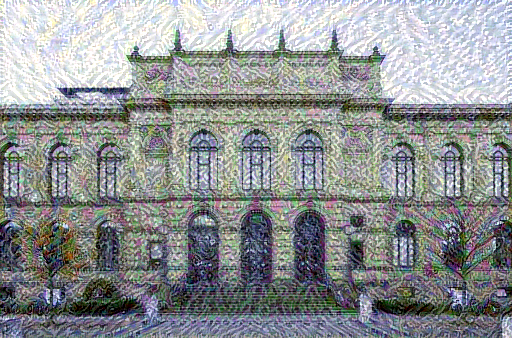

Train step: 10
Total time: 38.1


In [48]:
start = time.time()
epochs = 1
steps_per_epoch = 10 
step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        loss = train_step(extractor, image, style_targets, content_targets, style_weight, content_weight,
               num_style_layers, num_content_layers, opt)
        print(".", end='')
    print(loss)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))
end = time.time()
print("Total time: {:.1f}".format(end-start))

Schließlich speichern wir das generierte Bild.

In [49]:
file_name = 'altgebaeude_stilisiert.png'
tensor_to_image(image).save(file_name)

## 2.5 Hinzufügen von TV-Regularisierung

Mit *Neural Style Transfer* in obiger Form erzeugte Bilder weisen häufig hochfrequente Teile auf, sodass das Ergebnis in Gewisser Hinsicht als verrauscht wahrgenommen werden kann. Zur Abmilderung dieses Effektes kann man *TV-Regularisierung* zur Zielfunktion hinzufügen. Dabei werden (ganz grob) große Farbgradienten des generierten Bildes bestraft, sodass dieses lokal weniger variiert und glatter erscheint. Glücklicherweise steht in TensorFlow eine fertig implementierte Funktion für *TV-Regularisierung* zur Verfügung, die wir nun ein ```train_step``` einbauen wollen.

26. Initialisieren Sie ```total_variation_weight = 100```.

In [50]:
total_variation_weight = 100

27. Definieren Sie die TensorFlow-Funktion ```train_step``` erneut. Gehen Sie dabei genau wie oben vor, ergänzen Sie lediglich ```loss``` um ein Argument ```total_variation_weight``` und einen Summanden ```total_variation_weight * tf.image.total_variation(image)```.

In [51]:
@tf.function()
def train_step(extractor, image, style_targets, content_targets, style_weight, content_weight,
               num_style_layers, num_content_layers, opt,total_variation_weight):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs, style_targets, content_targets, style_weight, content_weight,
                       num_style_layers, num_content_layers) + total_variation_weight*tf.image.total_variation(image)
        
    
    grad = tape.gradient(loss,image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))
    return loss

28. Initialisieren Sie ```image``` erneut.

In [52]:
image = tf.Variable(content_image)

28. Führen Sie eine 25. entsprechende Schleife unter Verwendung der geänderten Funktion ```train_step``` aus.

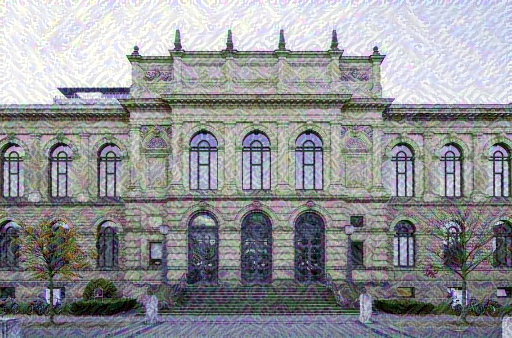

Train step: 10
Total time: 42.4


In [53]:
start = time.time()
epochs = 1
steps_per_epoch = 10 
step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        loss = train_step(extractor, image, style_targets, content_targets, style_weight, content_weight,
               num_style_layers, num_content_layers, opt,total_variation_weight)
        print(".", end='')
    print(loss)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))
end = time.time()
print("Total time: {:.1f}".format(end-start))

Wir speichern auch dieses Bild:

In [ ]:
file_name = 'altgebaeude_stilisiert_tv.png'
tensor_to_image(image).save(file_name)

## 2.6 Neural Art Contest

29. Legen Sie eine Datei ```style_transfer.py``` an und fügen Sie dort den benötigten Code ein, um *Neural Style Transfer* auf dem GPU-Cluster auszuführen und generierte Bilder zu speichern.

30. Beschaffen Sie sich verschiedene *Content Images*, deren Motive einen Bezug zur TU Braunschweig aufweisen (zum Beispiel Tentomax, HERMANs oder McMurphy's) sowie *Style Images* Ihrer Wahl und generieren Sie mindestens drei verschiedene Bilder.

**Checkpoint:** Genau drei Kombinationen aus *Content Image*, *Style Image* und *Generated Image* sowie der zugehörige Code sind abzugeben. Geben Sie insbesondere drei Dateien ```style_transfer_[1, 2, 3].py``` ab, mit Hilfe derer die abgegebenen generierten Bilder reproduziert werden können. Die abgegebenen Bilder werden im Rahmen des **Neural Art Contest am 05.02.2020** ausgestellt. Die Besucher können dann für Ihre Bilder abstimmen.

Abschließend noch einige Ideen und Hinweise, die Sie nutzen können, um Bilder auf dem GPU-Cluster zu generieren:

- Sie können in ```load_img``` einen höheren Wert für ```max_dim``` benutzen, um Bilder mit höherer Auflösung zu produzieren.
- Sie müssen die Variable ```image``` nicht mit ```content_image``` initialisieren. Zufällige oder konstante Initialisierung funktionieren ebenfalls.
- Sie können in den Listen ```content_layers``` und ```style_layers``` beliebige Teilmengen der Schichten von ```VGG19``` verwenden.
- Sie können ```content_weight```, ```style_weight``` und ```total_variation_weight``` modifizieren.
- Sie können ```tf.optimizers.Adam``` durch einen anderen Algorithmus ersetzen.
- Achten Sie darauf, dass Sie bei Nutzung des GPU-Clusters Kommandos weglassen, welche zur Ausgabe von Bildern führen. - - Die Unterscheidung zwischen ```steps``` und ```epochs``` ist dann hinfällig, es macht aber Sinn, deutlich mehr als 1000 Gradientenschritte auszuführen.
- Sie können während des Trainings innerhalb von ```train_step``` die Werte ```loss``` ausgeben lassen, um den Fortschritt besser einschätzen zu können.
